# **DCGAN-PSO**

Es un algoritmo de **neuroevolución** encargado de diseñar y entrenar Redes Generativas Adversarias (**GANs**).
Esta basado en un algoritmo de Inteligencia Colectiva (rama del Cómputo Evolutivo) conocido como Optimización por Cúmulo de Partículas (**PSO**).

A través de la evolución de una población (**Enjambre**) de arquitecturas de GAN (**Partículas**) se obtiene una GAN entrenada progresivamente escalando su resolución para realizar un entrenamiento menos complejo y, por lo tanto, más estable para la GAN. Se tomo como idea central lo desarrollado en (Karas et al. 2017).

![picture](https://drive.google.com/uc?export=view&id=189XM7ucvHRGS3_sp-eU0hXqLPzLioX9n)

## **Tipo de Neuroevolución**

El diseño de la **arquitectura** de las GANs es completamente evolucionado mediante el **PSO**, mientras que su **entrenamiento** progresivo se realiza mediante **retropropagación**.

![picture](https://drive.google.com/uc?export=view&id=1JJAZRvCl410ePMvTSUEuC4qriglnJZwA)

## **Codificación**
La codificación de la arquitectura de las GANs es **directa** mediante una **lista**. Cada módulo representa un **tipo de capa** y los **hiperparámetros** evolucionables. Mediante una sola lista se decodifica la arquitectura del **Generador** y el **Discriminador**.

![picture](https://drive.google.com/uc?export=view&id=1KXLe75_-10TxTh3FuDhtb03O19bR1HIy)

## **Optimización por Cúmulo de Partículas (PSO)**

![picture](https://drive.google.com/uc?export=view&id=1kE3rl-QvPZgKDMuVwOaX_bVjgBrKZgMb)


## **Operadores de evolución**
* Se utilizan un operador especial para obtener un **vector de diferencias** entre dos partículas.
![picture](https://drive.google.com/uc?export=view&id=17hHBzuuUVkK7ES-uWOVL7FA6z3WOnUUk)


* Se utilizan operadores para **actualizar** la **velocidad** y **posición** de la partícula.
![picture](https://drive.google.com/uc?export=view&id=16DYA13jIMUnPRlDpUEeqHWAW-B9p4jw7)

Estos operadores se tomaron y adaptaron de un algoritmo de neuroevolución para redes neuronales convolucionales (Junior y Jen, 2019)

## **Aptitud**
La aptitud de cada partícula decodificada y entrenada se mide utilizando lotes de imágenes sintéticas obtenidas del generador para calcular la Fréchet Inception Distance (**FID**), diseñada para evaluar a las GANs(Heusel et al. 2017). Esta medida utiliza la CNN **Inception v3** para obtener los vectores de características (**2048** valores númericos) del lote de imágenes sintéticas y un lote del mismo tamaño de imágenes reales, con ello se evalua la diferencia entre ambas distribuciones de datos. Entre menor sea este valor, mayor similitud hay entre ambos lotes de imágenes, siendo cero cuando son exactamente iguales.
![picture](https://drive.google.com/uc?export=view&id=1tA4WrnjF3HH6WiWf71-W6MEf5jmo4_s1)

## **Resultados**
Se utilizaron **radiografías de toráx** de pacientes con **COVID-19**. Se escaló de una resolución de **4x4** a **256x256** píxeles. Se realizó la medición mediante la métrica Fréchet Inception Distance (**FID**).
Animación con la evolución de las DCGAN: https://drive.google.com/file/d/1-rUoJldZSj2wx47H9-3QSojUn3oKscHd/view
![picture](https://drive.google.com/uc?export=view&id=11mst8TCChPUP8D1SFA1VHlGcXzB3syxA)

## **Artículo DCGAN-PSO**
Juan-Antonio Rodríguez-de-la-Cruz, Héctor-Gabriel Acosta-Mesa and Efrén Mezura-Montes, **Evolution of Generative Adversarial Networks using PSO for Synthesis of COVID-19 Chest X-Ray Images**, in Proceedings of the IEEE Congress on Evolutionary Computation, Krakow, Poland, IEEE Press, 2021

## **Referencias**
* Karras, T., Aila, T., Laine, S., & Lehtinen, J. (2017). Progressive growing of gans for improved quality, stability, and variation. arXiv preprint arXiv:1710.10196.
* Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). Gans trained by a two time-scale update rule converge to a local nash equilibrium. Advances in neural information processing systems, 30.
* Junior, F. E. F., & Yen, G. G. (2019). Particle swarm optimization of deep neural networks architectures for image classification. Swarm and Evolutionary Computation, 49, 62-74.


### **Cargar librerías**

In [ ]:
#Librerías PyTorch
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary
from torchvision.datasets import MNIST
import torchvision

#Librería para graficar
import matplotlib.pyplot as plt
#Librerías misceláneas
% matplotlib inline
import numpy as np
import os
import time
import pickle
from IPython import display

#Librería Tensorflow
import tensorflow as tf
from tensorflow import keras
from IPython import display
from tensorflow.keras import layers



#Librerías para calcular FID
import scipy
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input



### **Parámetros del algoritmo**

In [ ]:
####PARÁMETROS A CAMBIAR PARA EXPERIMENTAR####
tamaño_lote = 128 #Definir el tamaño de lote de acuerdo a la resolución actual
num_particulas  = 10  #N° de partíiculas en el enjambre
num_generaciones = 10  #Número de generaciones por cada resolución
Cg = 0.5  #Parámetro Cg
num_epocas = 15 #Número de épocas para entrenar cada partícula
tamaño_dataset = 1500 #Número de imágenes utilizadas en los conjuntos de entrenamiento
tamaño_comparar = 100 #N° de imágenes a comparar cuando se calcula el FID
#Parámetros para conocer en qué resolución comienza y hasta qué resolución evoluciona
resolucion_inicial = 4 #Resolución de la imagen creada por la primera capa Fully Connected
resolucion_actual = 32 #Resolución que se busca obtener
#Número de capas transpuestas que duplican la resolución de las creaciones
num_max_capas_T = int(np.log(resolucion_actual/resolucion_inicial)/np.log(2))
#Mínimo y máximo número de capas de las redes
min_capas = 4
max_capas = 6
#Mínimo y máximo número de neuronas en las capas Fully Connected
min_neuronas = 1
max_neuronas = 200
#Mínimo y máximo número de filtros en las capas de las redes
min_num_filtros = 1
max_num_filtros = 256
#Mínimo y máximo tamaño de los filtros
min_tamaño_filtros = 2
max_tamaño_filtros = 5


#Hiperparámetros para optimizadores (Adam)
tasa_aprendizaje = 0.0002
beta1 = 0.5
beta2 = 0.999
#Pendiente negativa de la función LeakyReLU
pendiente_negativa_LR = 0.2
#Número de valores aleatorios como entrada al generador (Dimensión z)
z_dim = 100
#Dispositivo para realizar el entrenamiento de las RN (necesario para PyTorch)
dispositivo = 'cuda'
#Número de imágenes de ejemplo a mostrar en el entrenamiento
num_imagenes_mostrar = 9
#Número de canales finales de las imágenes generadas. Un canal para imágenes en escala de grises
num_canales_final = 1
#Inicializador de pesos de las RN. Se utiliza una distribución normal
inicializador_redes = torch.nn.init.normal_
#Parámetros para inicializar pesos de las RN
media_inicializar = 0.0
desv_est_inicializar = 0.02
bias_inicializar = 0.0
#Función de costo
criterio = nn.BCEWithLogitsLoss()


### **Función para mostrar imágenes del generador entrenado**

In [ ]:
def mostrar_imagen(predicciones,num_imagenes_mostrar = 25):
  '''Función para mostrar mosaico de imágenes'''
  fig = plt.figure(figsize=(5,5))
  predicciones1 = predicciones[:num_imagenes_mostrar]
  image_tensor = (predicciones1+ 1) / 2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_imagenes_mostrar], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.axis('off')
  plt.show()

### **Obtener conjunto de imágenes MNIST**

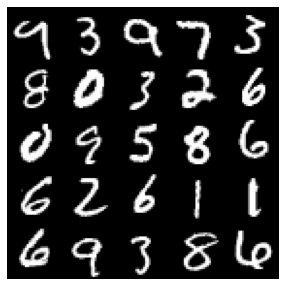

In [ ]:
#Semilla de aleatoriedad que permita obtener los mismos resultados
np.random.seed(0)
#Obtener imágenes del conjunto de datos MNIST
imagenes_mnist = MNIST('.', download=True,train=True).data.numpy()
#Normalizar las imágenes en el rango [-1,1]
imagenes_mnist = imagenes_mnist.reshape(-1,1,28,28).astype(np.float32)*2./255.0 -1. 
#Indices para escoger sólo una parte de todo el conjunto de datos
indices = np.random.choice(imagenes_mnist.shape[0],tamaño_dataset,replace=False)
#Escalar imágenes a una resolución 32x32
imagenes_entrenar = torch.nn.functional.interpolate(torch.tensor(imagenes_mnist[indices]),size=resolucion_actual).numpy()
#Crear el conjunto de datos para el entrenamiento de las GANs 
dataloader = DataLoader(imagenes_entrenar,
    batch_size=tamaño_lote,
    shuffle=True)
#Indices aleatorios para elgir las imágenes que serán comparadas para el cálculo de FID
indices = np.random.choice(imagenes_mnist.shape[0],tamaño_comparar,replace=False)
#Crear el conjunto de imagenes para introducir a Inception v3
imagenes_comparar = torch.nn.functional.interpolate(torch.tensor(imagenes_mnist[indices].reshape(-1,1,1,28,28)),size=(3,299,299)).numpy()
imagenes_comparar = imagenes_comparar.reshape(-1,299,299,3)


#Se elimina el arreglo de imágenes para vaciar la memoria
del imagenes_entrenar, imagenes_mnist

#Plasmar una muestra de imágenes
mostrar_imagen(torch.Tensor(imagenes_comparar.reshape(-1,3,299,299)))


### **Funciones para calcular la Fréchet Inception Distance (FID)**

In [ ]:
def calcular_FID(CNN, imagenes_1, imagenes_2):
    '''Función para calcular la Fréchet Inception Distance'''
    # Calcular activaciones de la CNN con los dos lotes de imágenes
    act_1 = CNN.predict(imagenes_1)
    act_2 = CNN.predict(imagenes_2)
    # Calcular media y covarianza de las activaciones
    mu_1, sigma_1 = act_1.mean(axis=0), np.cov(act_1, rowvar=False)
    mu_2, sigma_2 = act_2.mean(axis=0), np.cov(act_2, rowvar=False)
    # Calcular la suma de las diferencias cuadradas entre las medias
    diferencia_cuadrada = np.sum((mu_1 - mu_2)**2.0)
    #Calcular la raíz cuadrad del producto entre covarianzas
    raiz_cuad = scipy.linalg.sqrtm(sigma_1.dot(sigma_2))
    # Comprobar la correctez de los números complejos en la raíz
    if np.iscomplexobj(raiz_cuad):
      raiz_cuad = raiz_cuad.real
    # Calcular el puntaje
    fid = diferencia_cuadrada + np.trace(sigma_1 + sigma_2 - 2.0 * raiz_cuad)
    return fid

def evaluar_FID(reales,falsas):
  '''Función para procesar las imágenes para su introducción
     a Inception v3 y posteriormente calcular el FID con los
     vectores de características
  '''
  #Realizar copia de los arreglos de imágenes
  reales1 = reales.copy()
  falsas1 = falsas.copy()
  #Pre-procesar las imágenes para su correcta entrada a Inception v3. Normalizar en el rango [-1,1]
  imagenes_reales = preprocess_input(reales1)
  imagenes_falsas = preprocess_input(falsas1)  
  #Calcular FID
  fid = calcular_FID(inception_modelo, imagenes_reales, imagenes_falsas)
  #Truncar FID a cinco decimales
  fid = round(fid, 5)
  return fid

# Cargar la red pre-enetrenada Inception v3
inception_modelo = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

### **Función para evaluar la Aptitud de las partículas entrenadas**

In [ ]:
def evaluar_aptitud(generador):
   #Modo de evaluación del generador, necesario para evaluar correctamente su desempeño 
   generador.eval()
   #Generar sólo 500 imágenes por cada vez que se llama el generador para no sobrecargar la memoria disponible
   imagenes_por_lote = 50 
   #N° de veces que se necesitará llamar al generador para obtener tantas imágenes sintéticas como las que contiene el conjunto de entrenamiento
   num_lotes = tamaño_comparar // imagenes_por_lote
   #Imágenes que faltaría obtener para llegar al mismo número que las imágenes de entrenamiento
   diferencia = tamaño_comparar - (num_lotes * imagenes_por_lote)
   for i in range(num_lotes):
      #Se obtiene el ruido aleatorio
      semilla = obtener_ruido(imagenes_por_lote, z_dim, dispositivo=dispositivo)
      #Si es el primer lote de imágenes
      if i == 0:
        #Se crea el arreglo de imágenes. Estas se redimensiona en la forma (n° muestras, resolucion_actual, resolucion_actual, 1) ya que esa
        #es la forma de las dimensiones que acepta la red Inception v3
        falsas = generador(semilla).to('cpu').detach().numpy().reshape(-1, 1, resolucion_actual, resolucion_actual)
      #Los siguientes lotes de imágenes
      else:
        #Se obtiene el lote de imágenes
        temp = generador(semilla).to('cpu').detach().numpy().reshape(-1, 1, resolucion_actual, resolucion_actual)
        #Se concatena al lote previamente creado
        falsas = np.concatenate((falsas, temp), axis=0)
   #Si faltan imágenes que añadir
   if diferencia > 0:
      #Se obtiene el ruido aleatorio
      semilla= obtener_ruido(diferencia,z_dim,dispositivo=dispositivo)
      #Se crea el lote de imágenes
      temp = generador(semilla).to('cpu').detach().numpy().reshape(-1,resolucion_actual,resolucion_actual,1)
      #Se concatena al lote previamente creado
      falsas = np.concatenate((falsas, temp), axis=0)
   #Redimensionar imagenes
   falsas = torch.nn.functional.interpolate(torch.tensor(falsas.reshape(-1,1,1,resolucion_actual,resolucion_actual)),size=(3,299,299)).numpy()
   falsas = falsas.reshape(-1,299,299,3)
   #Se calcula el FID con ambos lotes de imágenes, las de entrenamiento y las generadas 
   aptitud = evaluar_FID(imagenes_comparar, falsas)
   #Retornar la aptitud calculada 
   return aptitud

### **Función para inicializar los pesos de las RN**

In [ ]:
def iniciar_pesos(capa):
    '''Función para inicializar los pesos de las RN con una distribución normal'''
    #Si es una capa de naturaleza convolucional no tendrá bias
    if isinstance(capa, nn.Conv2d) or isinstance(capa, nn.ConvTranspose2d):
        inicializador_redes(capa.weight, media_inicializar, desv_est_inicializar)
    #Si es una capa de BatchNormalization tendrá bias
    if isinstance(capa, nn.BatchNorm2d):
        inicializador_redes(capa.weight, media_inicializar, desv_est_inicializar)
        torch.nn.init.constant_(capa.bias, bias_inicializar)

### **Función para inicializar partículas y enjambre**

In [ ]:
#Cada generador será una lista de listas, cada lista interna tendrá la definición y parámetros de una capa, por ejemplo:
#[[FC,4*4*1024],[T,1024,2],[C,250,4]] representa una red con una capa FC de 16,384 neuronas (el 4*4 se refiere al tamaño que queremos
#obtener al pasar por la primera convolución transpuesta y el 1024 el n° de filtros que tendrá esa primera capa, por lo que primero se
#tiene que saber el tamaño de la imagen que saldrá después de la primera TC y el n° de filtros en esta); después una Convolucional Transpuesta
# con 1024 filtros de tamaño 2*2; por último una capa de Convolucional que conserva el tamaño, con 250 filtros y un tamaño de 4*4.

#El tamaño final de esta red se obtiene contando el n° de transpuestas convolucionales que no mantiene el tamaño por dos y luego por el tamaño
#de la imagen al salir de la capa FC. En la anterior red ya que hay una capa T y el tamaño inicial es de 4, se tiene que: 1*2*4=8 por lo que 
#el tamaño final de la imagen será 8*8, por lo que el n° máximo de T será igual a 4 porque de 4*4 hasta 64*64 se necesitan 4 capas que dupliquen T

def inicializar_particula(inicio=True):
  'Función para inicializar una partícula aleatoriamente'
  #Número de capas que tendrá la red elegido aleatoriamente en el rango [min_capas,max_capas]
  num_max_capas = np.random.randint(min_capas, max_capas+1)
  #Lista que contendrá las capas y sus parámetros
  particula = []
  if inicio == True: #Si es el primer enjambre (o sea la resolución=4^2) necesita al principio una capa FC, en caso contrario no es necesaria la capa FC
    #Número de neuronas que tendrá la capa FC elegido aleatoriamente en el rango [min_neuronas, max_neuronas]
    numero_neuronas = np.random.randint(min_neuronas, max_neuronas+1)
    #Se agrega la descripción en forma de lista de la capa FC (el resolucion_inicial*resolucion_inicial es porque empezará en una resolución de 4*4)
    particula.append(['FC', resolucion_inicial*resolucion_inicial*numero_neuronas])
    num_max_capas -= 1 #Se resta una capa, ya que sólo faltan n-1 capas, ya que una ya se ocupó
  #Contador de la capas Transpuestas convolucionales que duplican la resolución. Se requiere un registro para no escalar de más la imagen.
  num_capas_T = 0
  #Por las n_capas capas que faltan de la red
  for i in range(num_max_capas):
    #Se calcula el número de transpuestas faltantes (ya que se necesitan 4 para llegar de 4*4 a 64*64)
    #Ejemplo: Si ya van 3 capas T y va en la i=6 con un máximo de capas de 10, entonces:
    #4-3 < (10-1)-6, significa que aún quedan 3 capas que insertar y sólo falta una capa Transpuesta por lo que se puede dejar al azar. 
    if num_max_capas_T-num_capas_T  < (num_max_capas)-i:
      #Se elige un número aleatorio 0 ó 1 y dependiendo de ese valor es la capa que se agrega
      aleat = np.random.randint(2)
      #Si el aleatorio es 0 y aún falta agregar más capas T
      if aleat == 0 and num_capas_T < num_max_capas_T:
        #Se elige aleatoriamente el n° de filtros que tendra la capa y el tamaño de esta
        numero_filtros = np.random.randint(min_num_filtros, max_num_filtros+1)
        tamaño_filtros = np.random.randint(min_tamaño_filtros, max_tamaño_filtros+1)
        #Se añade a la lista del generador esta capa con sus parámetros
        particula.append(['T', numero_filtros, tamaño_filtros])
        #Se suma uno al contador de estas capas
        num_capas_T += 1
      #Si es cero se agrega una capa Convolucional que mantiene el tamaño, o sea, una TM
      else:
        #Se eligen aleatoriamente los parámetros de esta capa
        numero_filtros = np.random.randint(min_num_filtros, max_num_filtros+1)
        tamaño_filtros = np.random.randint(min_tamaño_filtros, max_tamaño_filtros+1)
        #Se añade la descripción de la capa a la red
        particula.append(['C',numero_filtros,tamaño_filtros])
    ##Si sólo quedara el número justo de capas para insertar las restantes Transpuestas que duplican el tamaño, 
    #entonces se inserta obligatoriamente una Transpuesta que duplica la resolución
    else:
      #Se elige aleatoriamente el n° de filtros que tendra la capa y el tamaño de esta
      numero_filtros = np.random.randint(min_num_filtros, max_num_filtros+1)
      tamaño_filtros = np.random.randint(min_tamaño_filtros, max_tamaño_filtros+1)
      #Se añade a la lista del generador esta capa con sus parámetros
      particula.append(['T', numero_filtros, tamaño_filtros])
      #Se suma uno al contador de estas capas
      num_capas_T += 1

  #Se regresa la lista representando a la partícula
  return particula
  

def inicializar_enjambre(num_particulas,inicio=True):
  '''Función para inicializar el enjambre añadiendo tantas partículas como se necesite'''
  #El parámetro inicio sirve para indicar que se necesitan partículas con capa FC al principio
  #esto sólo se requiere cuando se inicia la corrida en una resolución de 4^2
  enjambre = []
  for i in range(num_particulas):
    enjambre.append(inicializar_particula(inicio=inicio))
  return enjambre

### **Función para redimensionar salida de las capas Fully Connected a una imagen de 4*4** 

In [ ]:
class Redimensionar_FC(nn.Module):
    '''
    Clase de PyTorch para redimensionar la salida de la primera capa Fully Connected a la forma de una imágen de 4*4*canales para su entrada
    en las siguientes capas convolucionales 
    '''
    #Recibe de entrada las dimensiones de a las cuales redimensionar
    def __init__(self, dimensiones):
        super().__init__()
        self.dimensiones = dimensiones

    def __repr__(self):
        return f'Redimensionar_FC{self.dimensiones}'

    def forward(self,entrada):
        '''
        Redimensionar la entrada de acuerdo a las dimensiones establecidas en su creación
        '''
        #La primera dimsensión de la entrada indica el tamaño del lote (n° de imágenes o entradas)
        tamaño_lote = entrada.size(0)
        #Crear las nuevas dimensiones con el tamaño de lote
        dimensiones = (tamaño_lote,*self.dimensiones)
        #Obtener la salida con las nuevas dimensiones
        return entrada.view(dimensiones)
        

### **Función para definir los hiperparámetros de las capas de naturaleza convolucional**

In [ ]:
#Función para definir hiperparámetros de las capas 
#Se cambian sólo los valores de stride (1 para conservar tamaño y 2 para duplicarlo).
#Se cambian los valores de 'output_padding' para ajustar el tamaño saliente de la imagen.

#Caso 1: Se tiene una capa Transpuesta convolucional que se encarga de duplicar las dimensiones de la entrada (capa 'T').
#Para definirla se necesitan los hiperparámetros: stride, dilatación, output_padding y padding. Todos estos parámetros excepto 'padding' se mantienen fijos
#según el caso de que las dimensiones del filtro sean pares o impares. 'Padding' necesita ser calculado con la siguiente fórmula:
#Despejando 'Padding' en la fórmula para calcular las dimensiones de salida de una capa Transpuesta Conv. (https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)
#Padding = ((H_in-1) * stride + dil * (kernel_size - 1) + output_padding + 1 - H_out) / 2

#Caso 2: Se tiene ina capa Convolucional que conserva las dimensiones de la entrada (capa 'C').
#Para definirla se necesitan los hiperparámetros: stride, dilatación y padding. Todos estos parámetros excepto 'padding' se mantienen fijos
#según el caso de que las dimensiones del filtro sean pares o impares. 'Padding' necesita ser calculado con la siguiente fórmula:
#Despejando 'Padding' en la fórmula para calcular las dimensiones de salida de una capa Convolucional (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
#Padding = ((H_out-1) * stride - H_in + dilation * (kernel_size - 1) + 1) / 2 
def definir_hiperparametros(tipo_capa, tamaño_filtro, dimension_entrada):
  '''Función para calcular el padding de las capas trasnpuesta convolucional para que se obtengan
     salidas que dupliquen o conserven el tamaño de entrada según sea el caso
  '''
  #Si el fitlro tiene un tamaño par
  if tamaño_filtro % 2 == 0:
    #Si es una capa para conservar el tamaño de entrada, se inserta una capa Convolucional
    if tipo_capa == 'C':
      #Se conserva la dimsensión de entrada
      dimension_salida = dimension_entrada
      #Se fijan los hiperparámetros necesarios para obtener la salida deseada
      output_padding = 0 
      stride = 1
      dilatacion = 2
      #Se calcula el padding mediante la fórmula despejada anteriormente mencionada
      padding = ((dimension_salida - 1) * stride - dimension_entrada + (dilatacion * (tamaño_filtro - 1)) + 1) / 2
    #Si es una capa para duplicar el tamaño de entrada
    elif tipo_capa == 'T':
      #Se duplica la dimensión de salida
      dimension_salida = dimension_entrada * 2
      #Se fijan los hiperparámetros necesarios para obtener la salida deseada
      output_padding = 0
      stride = 2
      dilatacion = 1
      #Se calcula el padding mediante la fórmula despejada anteriormente mencionada
      padding = ((dimension_entrada - 1) * stride + dilatacion * (tamaño_filtro - 1) + output_padding + 1 - dimension_salida) / 2
  #Si el filtro tiene tamaño impar
  else:
    #Si es una capa para conservar el tamaño de entrada, se inserta una capa Convolucional
    if tipo_capa == 'C':
      #Se conserva la dimsensión de entrada
      dimension_salida = dimension_entrada
      #Se fijan los hiperparámetros necesarios para obtener la salida deseada
      output_padding = 0
      stride = 1
      dilatacion = 1
      #Se calcula el padding mediante la fórmula despejada anteriormente mencionada
      padding = ((dimension_salida - 1) * stride - dimension_entrada + (dilatacion * (tamaño_filtro - 1)) + 1) / 2
    #Si es una capa para duplicar el tamaño de entrada
    elif tipo_capa == 'T':
      #Se duplica la dimensión de salida
      dimension_salida = dimension_entrada * 2
      #Se fijan los hiperparámetros necesarios para obtener la salida deseada
      output_padding = 1
      stride = 2
      dilatacion = 1
      #Se calcula el padding mediante la fórmula despejada anteriormente mencionada
      padding = ((dimension_entrada - 1) * stride + dilatacion * (tamaño_filtro - 1) + output_padding + 1 - dimension_salida) / 2

  #Regresar los hiperparámetros necesarios para definir la capas de naturaleza convolucional
  return int(padding), int(output_padding), int(stride), int(dilatacion)

### **Función para crear las capas para el Generador**

In [ ]:
def obtener_capas_generador(canales_entrada, canales_salida, tamaño_filtro = 3, stride = 2, padding = 2, dilatacion = 1, output_padding = 1, capa_final = False):
    '''Función para crear las capas de naturaleza convolucional para el Generador con Normalización de pesos (Weight Normalization), esto mediante
      la función de PyTorch (nn.utils.weight_norm)
    '''
    #Si el stride es igual a dos entonces es una capa que desea duplicar el tamaño de la entrada, o sea, una capa transpuesta convolucional
    if stride == 2:
      #Si no es la capa final, entonces se inserta un bloque de capas compuesto por una capa transpuesta convolucional + capa Batch normalization + capa ReLU 
      if not capa_final:
          return nn.Sequential(
                nn.utils.weight_norm(nn.ConvTranspose2d(canales_entrada, canales_salida, tamaño_filtro, stride, padding=padding, dilation=dilatacion, output_padding=output_padding, bias=False)),
                nn.BatchNorm2d(canales_salida),
                nn.ReLU(inplace=True),
          )
      #Si es la capa final, sólo se usa la capa transpuesta convolucional + Tanh
      else:
          return nn.Sequential(
              nn.utils.weight_norm(nn.ConvTranspose2d(canales_entrada, canales_salida, tamaño_filtro, stride, padding=padding, dilation=dilatacion, output_padding=output_padding, bias=False)),
              nn.Tanh(),
          )
    #Si el stride es de 1, entonces se inserta una capa convolucional que mantiene el tamaño de entrada
    else:
      #Si no es la capa final, entonces se inserta un bloque de capas compuesto por una capa convolucional + capa Batch normalization + capa ReLU 
      if not capa_final:
          return nn.Sequential(
              nn.utils.weight_norm(nn.Conv2d(canales_entrada, canales_salida, tamaño_filtro, stride, padding=padding, dilation=dilatacion, bias=False)),
              nn.BatchNorm2d(canales_salida),
              nn.ReLU(inplace=True),
          )
      #Si es la capa final, sólo se usa la capa convolucional + Tanh
      else:
          return nn.Sequential(
              nn.utils.weight_norm(nn.Conv2d(canales_entrada, canales_salida, tamaño_filtro, stride, padding=padding, dilation=dilatacion, bias=False)),
              nn.Tanh(),
          )

### **Función para crear las capas para el Discriminador**

In [ ]:
def obtener_capas_discriminador(canales_entrada, canales_salida, tamaño_filtro = 4, stride = 2, capa_final = False):
    '''Función para crear las capas de naturaleza convolucional para el Discriminador con Normalización Espectral (Spectral Normalization), esto mediante
      la función de PyTorch (nn.utils.spectral_norm)
    '''
      
    #Si no es la capa final, entonces se inserta un bloque de capas compuesto por una capa convolucional + capa Batch normalization + capa LeakyReLU 
    if not capa_final:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(canales_entrada, canales_salida, tamaño_filtro, stride)),
                nn.BatchNorm2d(canales_salida),
                nn.LeakyReLU(pendiente_negativa_LR, inplace=True),
            )
    #Si es la capa final, sólo se usa la capa convolucional
    else:
        return nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(canales_entrada, canales_salida, tamaño_filtro, stride)),
            )

### **Función para decodificar el generador a partir de la partícula (Lista)**

In [ ]:
def decodificar_generador(particula,z_dim):
  '''
    Función que decodifica un Generador a partir de la lista que define a la partícula
  '''
  #El número de capas es la longitud de la lista que encripta la particula.
  num_capas = len(particula)
  #Iniciar lista de capas
  capas = []
  #Variable que contiene la resolución de la imagen que se generará con las capas insertadas hasta el momento. Comienza con la resolución inicial de 4*4
  resolucion_actual = resolucion_inicial
  #Variable que contiene el n° de canales de entrada de cada nueva capa, este se actualiza según los canales de salida de la capa previa.
  #Al inicio recibe tantos canales como números aleatorios de entrada al generador (z_dim)
  canales_entrada = z_dim
  #Añade una capa FC con el número de neuronas que indica la primera capa de la partícula en su 2da posición. 
  #Notar que se utiliza la normalización de pesos proporcionada por la librería de PyTorch (nn.utils.weight_norm)
  capas.append(nn.utils.weight_norm(nn.Linear(canales_entrada, particula[0][1])))
  #Se actualiza el tamaño de entrada, este será el mismo que el n° de canales de salida de la capa anterior.
  #Recordar que cuando se inicializaron las partículas (función 'Inicializar partícula') se múltiplico el n° de neuronas por la resolución inicial, por lo que
  #se tendrá un canal por cada neurona de la capa Fully Connected y de resolución tamaño_inicial*tamaño_inicial
  canales_entrada = int(particula[0][1] / (resolucion_inicial*resolucion_inicial))
  #Se inserta una capa de la clase 'Redimensionar_FC' que realizará la redimensión de las salidas de la capa Fully Connected
  capas.append(Redimensionar_FC((canales_entrada, resolucion_inicial, resolucion_inicial)))
  #Por cada capa faltante en la partícula
  for i in range(1, num_capas):
    #Si la particula es una transpuesta que duplica las dimensiones de entrada
    if particula[i][0] == 'T':
      tamaño_filtro = particula[i][2]
      if tamaño_filtro > resolucion_actual:
        tamaño_filtro = resolucion_actual
      #Calcular hiperparámetros necesarios (padding, output_padding, stride, dilatación) para que la capa cumpla con su meta de duplicar las 
      #dimensiones de entrada, estos se calculan con la función 'definir_hiperparametros'
      padding, output_padding, stride, dilatacion = definir_hiperparametros('T', tamaño_filtro, resolucion_actual)
      #Añadir una capa transpuesta que duplica las dimensiones de la entrada con los hiperparámetros calculados utilizando la función 'obtener_capas_generador'
      capa = obtener_capas_generador(canales_entrada, particula[i][1], tamaño_filtro = tamaño_filtro, stride=stride, padding = padding, dilatacion=dilatacion, \
                         output_padding = output_padding, capa_final=False)
      #Añadir la capa obtenida a la lista de capas
      capas.append(capa)
      #Se duplica la resolución, ya que se insertó una capa que duplica las dimensiones de la entrada
      resolucion_actual *= 2
      #Se actualizan los canales de entrada con el número de canales de salida indicados por la lista de la partícula
      canales_entrada = particula[i][1]
    #Si la cpa es una convolucional que conserva las dimensiones de la entrada  
    elif particula[i][0] == 'C':
      tamaño_filtro = particula[i][2]
      if tamaño_filtro > resolucion_actual:
        tamaño_filtro = resolucion_actual
      #Calcular hiperparámetros necesarios (padding, output_padding, stride, dilatación) para que la capa cumpla con su meta de duplicar las 
      #dimensiones de entrada, estos se calculan con la función 'definir_hiperparametros'
      padding, output_padding, stride, dilatacion = definir_hiperparametros('C', tamaño_filtro, resolucion_actual)
      #Añadir una capa transpuesta que duplica las dimensiones de la entrada con los hiperparámetros calculados utilizando la función 'obtener_capas_generador'
      capa = obtener_capas_generador(canales_entrada, particula[i][1], tamaño_filtro = tamaño_filtro, stride=stride, padding = padding, dilatacion=dilatacion, \
                         output_padding = output_padding, capa_final=False)
      #Añadir la capa obtenida a la lista de capas
      capas.append(capa)
      #Se actualizan los canales de entrada con el número de canales de salida indicados por la lista de la partícula
      canales_entrada = particula[i][1]
      #NOTA: No se actualizó la resolución actual ya que al ser una capa que mantiene el tamaño de la entrada entonces la resolución permanece igual

  #Por último se añade una capa Convolucional que conserva el tamaño de la entrada con un filtro de tamaño uno para 'pulir' la salida del generador
  #Calcular hiperparámetros necesarios (padding, output_padding, stride, dilatación) para que la capa cumpla con su meta de duplicar las 
  #dimensiones de entrada, estos se calculan con la función 'definir_hiperparametros'
  padding, output_padding, stride, dilatacion = definir_hiperparametros('C', 1, resolucion_actual)
  capa = obtener_capas_generador(canales_entrada, 1, tamaño_filtro = 1, stride=stride, padding = padding, dilatacion=dilatacion, \
                      output_padding = output_padding, capa_final=True)
  #Añadir la capa obtenida a la lista de capas
  capas.append(capa)
  #Crear el generador con la secuencia de capas en la lista
  generador = nn.Sequential(*capas)
  #Regresar el Generador
  return generador

### **Función para decodificar el discriminador a partir de la partícula (Lista)**

In [ ]:
def decodificar_discriminador(particula, num_canales = num_canales_final, resolucion = resolucion_actual):
  '''
    Función que decodifica un Discriminador a partir de la lista que define a la partícula
  '''
  #Se realiza una copia de la lista y se invierte su secuencia
  particula_inversa = particula.copy()
  particula_inversa.reverse()
  #El número de capas es la longitud de la lista que encripta la particula
  num_capas = len(particula_inversa)
  #Número de canales 
  num_canales_actual = num_canales
  #Resolución actual
  resolucion_actual = resolucion
  #Iniciar lista de capas 
  capas = []
  #Iniciar lista donde se encuentren los índices de las capas de tipo T que son las que se convertirán a Convolucionales que reducen
  #las dimensiones de la entrada
  indices_transpuestas = []
  #Añadir los índices de la partícula donde se encuentran las capas del tipo T 
  for i in range(num_capas):
     if particula_inversa[i][0] == 'T':
        indices_transpuestas.append(i)

  #Por cada capa del tipo T en la partícula
  for indice in indices_transpuestas:
    #Comprobar que la resolución actual no sea mayor que el tamaño del filtro a poner, ya que eso no es posible de implementar
    if particula_inversa[indice][2] > resolucion_actual:
      tamaño_filtro =  resolucion_actual
    else:
      tamaño_filtro = particula_inversa[indice][2]
    #Se añade una capa Convolucional con normalización espectral 
    capa = obtener_capas_discriminador(num_canales_actual, particula_inversa[indice][1], tamaño_filtro = tamaño_filtro)
    #Añadir la capa a la lista de capas
    capas.append(capa)
    #Se actualiza el número de canales
    num_canales_actual = particula_inversa[indice][1]
    #Se calcula la nueva resolución con la fórmula de las capas Convolucionales (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
    resolucion_actual = np.floor(((resolucion_actual - (tamaño_filtro - 1) - 1) / 2) + 1 )
    

  #Añadir capa final Fully Connected que se encuentra al final de la partícula inversa.
  #Primero calcular el número de entradas a la capa FC
  num_pixeles = int(resolucion_actual * resolucion_actual * num_canales_actual)
  #Añadir capa que 'aplane' esos valores de las capas convolucionales
  capas.append(Redimensionar_FC(([num_pixeles])))
  #Insertar la capa FC con los canales solicitados
  
  capas.append(nn.utils.spectral_norm(nn.Linear(int(num_pixeles),int(particula_inversa[-1][1] / (resolucion_inicial * resolucion_inicial)))))
  #Insertar capa FC que convierta obtenga el valor final que servirá como predicción.  El '1' en la capa representa que sólo se requiere una salida (predicción)
  capas.append(nn.utils.spectral_norm(nn.Linear(int(particula_inversa[-1][1] / (resolucion_inicial * resolucion_inicial)), 1)))
  #Se crea el discrimnador con la secuencia de las capas
  discriminador = nn.Sequential(*capas)
  #Se retorna el discriminador
  return discriminador




### **Función para obtener ruido aleatorio**

In [ ]:
def obtener_ruido(num_muestras, z_dim, dispositivo='cpu'):
    '''Función para obtener el ruido aleatorio normal que será la entrada al generador'''
    return torch.randn(num_muestras, z_dim, device=dispositivo)

### **Función para realizar el entrenamiento**

In [ ]:
def paso_entrenamiento(imagenes, generador, gen_opt, discriminador, disc_opt):
  '''Función para realizar el entrenamiento de la GAN'''
  tamaño_lote_actual = len(imagenes)
  imagenes = imagenes.to(dispositivo)
  ## Actualizar discriminador ##
  disc_opt.zero_grad()
  ruido_falso = obtener_ruido(tamaño_lote_actual, z_dim, dispositivo=dispositivo)
  falso = generador(ruido_falso)
  pred_disc_falso = discriminador(falso.detach())
  perd_pred_disc_falso = criterio(pred_disc_falso, torch.zeros_like(pred_disc_falso))
  pred_disc_real = discriminador(imagenes)
  perd_pred_disc_real= criterio(pred_disc_real, torch.ones_like(pred_disc_real))
  perdida_discriminador = (perd_pred_disc_falso + perd_pred_disc_real) / 2
  # Actualizar gradientes
  perdida_discriminador.backward(retain_graph=True)
  # Actualizar optimizador
  disc_opt.step()

  ## Actualizar generador ##
  gen_opt.zero_grad()
  ruido_falso_2 = obtener_ruido(tamaño_lote_actual, z_dim, dispositivo=dispositivo)
  falso_2 = generador(ruido_falso_2)
  pred_disc_falso = discriminador(falso_2)
  perdida_generador = criterio(pred_disc_falso, torch.ones_like(pred_disc_falso))
  #Actualizar gradientes
  perdida_generador.backward()
  #Actualizar generador
  gen_opt.step()

### **Función para realizar el entrenamiento completo de una partícula**

In [ ]:
def entrenar(particula, num_epocas, dataset):
    #Se decodifica el generador
    gen = decodificar_generador(particula,z_dim).to(dispositivo)
    #Se inicializan los pesos del generador
    gen = gen.apply(iniciar_pesos)
    #Se inicializa el optimizador del generador (Adam)
    gen_opt = torch.optim.Adam(gen.parameters(), lr = tasa_aprendizaje, betas = (beta1, beta2))
    #Se decodifica el discriminador
    disc = decodificar_discriminador(particula).to(dispositivo)
    #Se inicializa el optimizador del discriminador (Adam) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr = tasa_aprendizaje, betas = (beta1, beta2))
    #Se inicializan los pesos del discriminador
    disc = disc.apply(iniciar_pesos)
    #Por el número de épocas definido
    for epoca in tqdm(range(num_epocas)):
      #Por cada mini-lote de imágenes del conjunto de imágenes completo
        for real in dataset:
          paso_entrenamiento(real, gen, gen_opt, disc, disc_opt)
    #Retornar el generador y el discriminador      
    return gen, disc

### **Función para crear una capa creada aleatoriamente**

In [ ]:
def regresar_capa(tipo_capa):
    '''
      Función que regresa una capa con hiperparámetros aleatorios
    '''
    if tipo_capa == 'FC':
      numero_neuronas = np.random.randint(min_num_filtros,max_num_filtros+1)
      #Si es una capa FC esta sólo se maneja con la resolución inicial
      return ['FC',resolucion_inicial*resolucion_inicial*numero_neuronas]
    elif tipo_capa == 'T':
      #Se elige aleatoriamente el n° de filtros que tendra la capa y el tamaño de esta
      numero_filtros = np.random.randint(min_num_filtros,max_num_filtros+1)
      tamaño_kernel = np.random.randint(min_tamaño_filtros,max_tamaño_filtros+1)
      #Se añade a la lista del generador esta capa con sus parametros
      return ['T',numero_filtros,tamaño_kernel]
    else:
      #Se elige aleatoriamente el n° de filtros que tendra la capa y el tamaño de esta
      numero_filtros = np.random.randint(min_num_filtros,max_num_filtros+1)
      tamaño_kernel = np.random.randint(min_tamaño_filtros,max_tamaño_filtros+1)
      #Se añade a la lista del generador esta capa con sus parametros
      return ['C',numero_filtros,tamaño_kernel]

### **Función para actualizar las partículas**

In [ ]:
def actualizar_particula(gbest, pbest, particula):
  '''
    Función para actualizar las partículas utilizando el gBest y pBest
  '''
  #Se toma la longitud del mayor de las partículas, ya que esas dos serán las prioritarias en la comparación, por lo que aunque la partícula sea más grande
  #que estas dos, después de la actualización no podrá ser más grande que las partícula más larga contra la que compararse, cualquier exceso será eliminado.
  if len(gbest) > len(pbest):
    longitud = len(gbest)
  else:
    longitud = len(pbest)
  #Inicializar lista de capas de la nueva partícula
  nueva_particula=[]
 
  #Para todas la capas a partir de un índice de partida (ya que cuando la arquitectura ya este fija en un determinado tamaño entonces
  #no se pueden cambiar las capas anteriores)
  for i in range(longitud):
    #Aleatorio para decidir si se comparará con gbest o pbest
    r = np.random.uniform()
    try:
      tipo_capa = particula[i][0]
       #Si la partícula es una Fully Connected
      if tipo_capa == 'FC':
        #Comparar con el gbest
        if r <= Cg:
          #Si el número de neuronas son iguales del gbest y la particula
          if particula[0][1] == gbest[0][1]:
            #Se conserva la misma capa FC de la particula
            nueva_particula.append(particula[0]) 
          #Si no se agrega la del mejor global
          else:
            nueva_particula.append(regresar_capa(gbest[0][0]))
        
        else:
          #Si la particula y el pbest tienen el mismo número de neuronas
          if particula[0][1] == pbest[0][1]:
            #Se conserva la capa FC de la particula
            nueva_particula.append(particula[0]) 
          else:
            #Si no se toma la del pbest
            nueva_particula.append(regresar_capa(pbest[0][0]))
    #Caso cuando alguna de las partículas termina
    except IndexError:
      pass
    #Si la partícula es una capa convolucional ('C') o convolucional transpuesta ('T')
    if tipo_capa == 'C' or tipo_capa == 'T':
      #Comparar con el gbest
      if r <= Cg:
        try:
          #Pueden darse tres casos:
          #1.- Tanto la particula como el gbest son igual de largos hasta esa posición, por lo cual se pueden comparar capas
          #2.- El gbest es más corto
          #3.- La partícula es más corta
          #Se lee el tipo de capa
          valor_particula = particula[i][0]
          valor_mejor = gbest[i][0]
          valor_local = pbest[i][0]
          #Si el tipo de capa de la partícula es igual a la del gbest
          if valor_particula == valor_mejor:
            #Y además el tipo de capa de la partícula es igual a la del pbest
            if valor_particula == valor_local:
              #Se agrega la capa del gbest, siguiendo el ejemplo de la Fig. 4 de Junior del caso especial donde los tipos de capas que tiene el pbest, gbest y la aprtícula son los mismos
              nueva_particula.append(gbest[i])
            #En caso de que no sea igual también al pbest se conserva el valor de la partícula, porque según la figura 3 si el gbest y la particula tienen la misma capa entonces se conserva intacta
            else:
              nueva_particula.append(particula[i])
          #Si son diferentes los tipos de capas, se le da preferencia al gbest y se conserva esa capa
          else:
            nueva_particula.append(gbest[i])
          #En el caso dos significa que como el gbest es la particula prioritaria en la diferencia eso significa que esa posición se debe eliminar de la partícula
          #por lo que al pasar al siguiente bloque, volverá a dar error llamar ese índice de el gbest por lo que continuará el algoritmo ignorando esa posición
          #En el caso tres, se agreagará a la nueva partícula un tipo de capa como la del gbest ya que tiene prioridad en la diferencia
        except IndexError:
          try:
            nueva_particula.append(regresar_capa(gbest[i][0]))
          except IndexError:
            continue
      
      #Los casos anteriores se repiten para cuando se elige el pbest
      else:
        try:
          valor_particula = particula[i][0]
          valor_local = pbest[i][0]
          valor_mejor = gbest[i][0]
          if valor_particula == valor_local:
            if valor_particula == valor_mejor:
              nueva_particula.append(pbest[i])
            else:
              nueva_particula.append(particula[i])
          else:
            nueva_particula.append(pbest[i])

        except IndexError:
          try:
            nueva_particula.append(regresar_capa(pbest[i][0]))
          except IndexError:
            continue
  #Listas que llevan el registro de dónde se encuentran las capas de tipo 'T' y 'C'
  indices_T = []
  indices_C = []
  for i in range(len(nueva_particula)):
    if nueva_particula[i][0] == 'T': 
      indices_T.append(i)
    else:
      indices_C.append(i)
  #Si faltan capas que doblan tamaño
  if len(indices_T) < num_max_capas_T:
    try:
      indices_cambiar = np.random.choice(len(indices_C),num_max_capas_T-len(indices_T),replace=False)
      for indice in indices_cambiar:
       
        #Se añade a la lista del generador esta capa con sus parametros
        nueva_particula[indices_C[indice]] = regresar_capa('T')
    except ValueError:
      nueva_particula.append(regresar_capa('T'))
    

   
    
  #Si hay más T que las permitidas
  elif len(indices_T) > num_max_capas_T:
    indices_cambiar = np.random.choice(len(indices_T),len(indices_T)-num_max_capas_T,replace=False)
    for indice in indices_cambiar:
    
      
      #Se añade a la lista del generador esta capa con sus parametros
      nueva_particula[indices_T[indice]] = regresar_capa('C')
    
  #Se retorna la nueva partícula
  return nueva_particula

### **Función para realizar el entrenamiento de un enjambre de partículas**

In [ ]:
def evolucionar(num_particulas, num_generaciones, num_epocas, dataset, resolucion_actual, num_imagenes_mostrar=25, inicio = False):
    '''
      Función para evolucionar el enjambre de partículas
    '''
    #Generación inicial
    generacion_actual = 1
    #Inicio el enjambre
    enjambre = inicializar_enjambre(num_particulas, inicio=inicio)
    #Genero un array con el valor de fitness de cada individuo (que empieza alto) FID más bajo mejor
    p_best_apt = [1000] * num_particulas
    #Inicializo la aptitud del mejor global
    g_best_apt = 1000
    #Inicializo la lista de los pBest
    p_bests = enjambre.copy()
    #Inicializo el mejor global
    g_best = None
    #Listas para realizar el seguimiento de la evolución de las partículas
    lista_aptitud_mejor = []
   

    
    #Semilla para las imágenes que se guardarán de prueba
    semilla = obtener_ruido(num_imagenes_mostrar, z_dim, dispositivo = dispositivo)
    for generacion in range(generacion_actual,num_generaciones+1):
      print('Generación:',generacion)
      #Lista con las aptitudes de la generación
      aptitudes_generacion = []
      #Por partícula en el enjambre y por cada indice
      for particula, num_particula in zip(enjambre, range(num_particulas)):
       
        print('Particula: ', num_particula+1)
        print('Codificación: ', particula)
        #Obtener el generador y el discriminador decodificando y entrenando la partícula
        gen, disc = entrenar(particula, num_epocas, dataset)
        #Evaluar la aptitud del generador
        print('Evaluando aptitud de la partícula...')
        aptitud = evaluar_aptitud(gen) #Evaluar el FID del generador
        print('Aptitud de la partícula: ', aptitud)
        aptitudes_generacion.append(aptitud) #Guardar la aptitud
        #Mostrar un lote imágenes sintéticas
        print('Lote de imágenes sintéticas:')
        mostrar_imagen(gen(semilla), num_imagenes_mostrar)
        print('')
        #Si su valor de FID es mejor que el valor de su mejor solución encontrada entonces cambiarla
        if aptitud < p_best_apt[num_particula]:
          p_best_apt[num_particula] = aptitud
          p_bests[num_particula] = particula
          #Si el valor de la aptitud es mejor que el de la mejor partícula del enjambre, entonces se reemplaza
          if aptitud < g_best_apt:
            g_best_apt = aptitud
            g_best = particula
              

    
        

      #Mostrar el mejor de la generación
      print('Mejor en la generación: ', generacion)
      print('Codificación de la mejor partícula: ', g_best)
      print('Aptitud del mejor: ', g_best_apt)
      print('Aptitudes de las mejores arquitecturas encontradas por cada partícula: ', p_best_apt)
      print('')


      #Se actualiza cada partícula del enjambre
      for i in range(num_particulas):
        enjambre[i] = actualizar_particula(g_best, p_bests[i], enjambre[i])
      lista_aptitud_mejor.append(g_best_apt)
      plt.figure(figsize=(7,8))
      plt.plot(list(range(1,len(lista_aptitud_mejor)+1,1)),lista_aptitud_mejor,'o-')
      plt.xticks(list(range(1,len(lista_aptitud_mejor)+1,1)))
      plt.title('Mejor aptitud por generación', fontweight='bold')
      plt.ylabel('FID', fontsize=16, fontweight='bold')
      plt.xlabel('Generación', fontsize=16, fontweight='bold')
      plt.xticks(fontsize=12)
      plt.yticks(fontsize=12)
      plt.show()
      print('')
   

Generación: 1
Particula:  1
Codificación:  [['FC', 1008], ['T', 177, 3], ['T', 212, 3], ['T', 161, 2], ['C', 174, 3]]



Evaluando aptitud de la partícula...
Aptitud de la partícula:  305.86709
Lote de imágenes sintéticas:


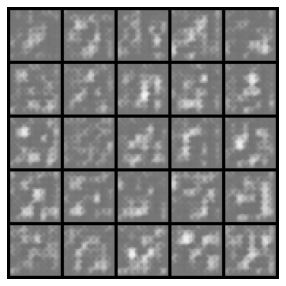


Particula:  2
Codificación:  [['FC', 2896], ['T', 217, 3], ['T', 144, 4], ['T', 152, 4], ['C', 220, 2]]


KeyboardInterrupt: ignored

In [ ]:
#Semillas de aleatoriedad para garantizar resultados iguales para todos. 
#Estos valores también se pueden cambiar para experimentar
torch.manual_seed(9) 
np.random.seed(26)
#Realizar el proceso de evolución
evolucionar(num_particulas, num_generaciones, num_epocas, dataloader, resolucion_actual, num_imagenes_mostrar=25, inicio = True)